In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-03-BIGDATA/master/init.py
import init; init.init(force_download=False); 
from IPython.display import Image

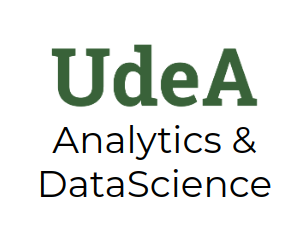

In [2]:
Image("local/imgs/udea-datascience.png")

# **TALLER 2: RDD**
## Desarrollado por: Mg. Efraín Alberto Oviedo; Ing. Kevin Martínez Gallego
## Universidad de Antioquia

Por favor, ingrese la información de cada integrante del grupo de trabajo

**Nombre Completo:**

**Cédula:**

**Correo Institucional:**

**Nombre Completo:**

**Cédula:**

**Correo Institucional:**

**Nombre Completo:**

**Cédula:**

**Correo Institucional:**

**Nombre Completo:**

**Cédula:**

**Correo Institucional:**

In [3]:
#Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz 
!pip install -q findspark

#Variables de Entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

#SparkContext
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

#**Análisis de becas académicas para estudiantes Colombianos**

El ICETEX ha dispuesto un histórico de becas ofrecidas para estudios de nivel de pregrado y posgrado, presenciales o virtuales, que han sido propuestas para fortalecer la formación académica de ciudadanos colombianos en el exterior.

(Disponible en https://www.datos.gov.co/Educaci-n/Icetex-Hist-rico-de-Becas/eb6r-dfgr)

Para cada caso se reportan los siguientes datos:

* Código Convocatoria
* Nombre del Oferente: Nombre del gobierno que ofrece la beca.
* Área del Conocimiento
* Nombre del Programa
* Nombre del País
* Fecha de Recepción -mm/dd/aaaa
* Perfil del Aplicante
* Objetivo del Programa: Breve descripción del programa académico.

Se solicita de su ayuda para responder a los siguientes interrogantes:

##**A) Calidad de datos**

Revise cada una de las variables disponibles y resuelva los problemas de calidad de datos que puedan afectar el desarrollo de este taller, justificando las razones de su decisión para cada caso


Presente aquí el código desarrollado y el resultado obtenido

In [4]:
raw = sc.textFile("local/data/icetex_becas.csv")
raw.take(5)

['Codigo Convocatoria,Nombre del Oferente,Area del Conocimiento,Nombre del programa,Nombre del País,Fecha de Recepción -mm/dd/aaaa,Perfil del Aplicante,Objetivo del Programa',
 '2127916.0,OEA - TOP - ARGENTINA,ADMINISTRACIÓN,POLÍTICAS DE GOBIERNO ABIERTO Y ACCESO A DATOS PÚBLICOS,PLATAFORMA DE EDUCACIÓN A DISTANCIA TOP - OEA,05/27/2016 12:00:00 AM,El programa está dirigido a profesionales universitarios en administración- economía- derecho- ciencias políticas o en áreas directamente relacionadas con el tema del curso que se desempeñen en entidades públicas o privadas- desarrollando actividades inherentes a las políticas de gobierno abierto y acceso a datos públicos. REQUISITOS: El candidato debe ser mayor de 23 años y menor de 65 años- tener un promedio mínimo de notas de pregrado de 3-7/5-0  contar con mínimo 2 años de experiencia profesional en el área del programa y gozar de buena salud física y mental.,a) Proporcionar a los participantes un panorama actualizado del concepto de Gobi

In [5]:
header = raw.first()
cols = header.split(",")
becas = raw.filter(lambda x: x!=header).map(lambda x: x.strip(',').split(','))
becas.take(2)

[['2127916.0',
  'OEA - TOP - ARGENTINA',
  'ADMINISTRACIÓN',
  'POLÍTICAS DE GOBIERNO ABIERTO Y ACCESO A DATOS PÚBLICOS',
  'PLATAFORMA DE EDUCACIÓN A DISTANCIA TOP - OEA',
  '05/27/2016 12:00:00 AM',
  'El programa está dirigido a profesionales universitarios en administración- economía- derecho- ciencias políticas o en áreas directamente relacionadas con el tema del curso que se desempeñen en entidades públicas o privadas- desarrollando actividades inherentes a las políticas de gobierno abierto y acceso a datos públicos. REQUISITOS: El candidato debe ser mayor de 23 años y menor de 65 años- tener un promedio mínimo de notas de pregrado de 3-7/5-0  contar con mínimo 2 años de experiencia profesional en el área del programa y gozar de buena salud física y mental.',
  'a) Proporcionar a los participantes un panorama actualizado del concepto de Gobierno Abierto.b) Analizar las principales tendencias con un abordaje teórico y práctico.c) Desarrollar y compartir conocimientos y habilidade

In [6]:
for i in range(8):
   num = becas.filter(lambda x:x[i]=='').count()
   val_distintos = becas.map(lambda x:x[i] if x[i]!='' else None).distinct().count()
   print(f"{cols[i]} - {num} nulos - {val_distintos} distintos")

Codigo Convocatoria - 0 nulos - 1471 distintos
Nombre del Oferente - 0 nulos - 207 distintos
Area del Conocimiento - 0 nulos - 38 distintos
Nombre del programa - 0 nulos - 768 distintos
Nombre del País - 0 nulos - 55 distintos
Fecha de Recepción -mm/dd/aaaa - 647 nulos - 349 distintos
Perfil del Aplicante - 0 nulos - 1418 distintos
Objetivo del Programa - 0 nulos - 1024 distintos


In [7]:
# Se ven alianzas y demás.
from datetime import datetime

In [8]:
!pip install Unidecode

In [9]:
import unidecode
def normalize_accent(x):
  return unidecode.unidecode(x)

In [10]:
def convert(x):

  date = x.pop(5)
  pais = [i.strip().upper() for i in x.pop(4).strip(')').split('(')]
  id_conv = float(x.pop(0))
  objetivo = normalize_accent(x.pop(-1)).lower()
  perfil = normalize_accent(x.pop(-1)).lower()
  
  if date!='':
    try:
      date = datetime.strptime(date,r"%d/%m/%Y %H:%M:%S %p")
    except:
      date = datetime.strptime(date,r"%m/%d/%Y %H:%M:%S %p") 

  return [id_conv] + x + [pais] + [date]  + [perfil] + [objetivo]

becas_clean = becas.map(lambda x: convert(x))

In [11]:
becas_clean.take(3)

[[2127916.0,
  'OEA - TOP - ARGENTINA',
  'ADMINISTRACIÓN',
  'POLÍTICAS DE GOBIERNO ABIERTO Y ACCESO A DATOS PÚBLICOS',
  ['PLATAFORMA DE EDUCACIÓN A DISTANCIA TOP - OEA'],
  datetime.datetime(2016, 5, 27, 12, 0),
  'el programa esta dirigido a profesionales universitarios en administracion- economia- derecho- ciencias politicas o en areas directamente relacionadas con el tema del curso que se desempenen en entidades publicas o privadas- desarrollando actividades inherentes a las politicas de gobierno abierto y acceso a datos publicos. requisitos: el candidato debe ser mayor de 23 anos y menor de 65 anos- tener un promedio minimo de notas de pregrado de 3-7/5-0  contar con minimo 2 anos de experiencia profesional en el area del programa y gozar de buena salud fisica y mental.',
  'a) proporcionar a los participantes un panorama actualizado del concepto de gobierno abierto.b) analizar las principales tendencias con un abordaje teorico y practico.c) desarrollar y compartir conocimientos

##**B) Aumento de ofertas de becas**

Identifique si la cantidad de becas ofrecidas para ciudadanos colombianos se ha incrementado con los años

Presente aquí el código desarrollado y el resultado obtenido

In [12]:
from operator import add
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
ofertas_año = becas.filter(lambda x:x[5]!='').map(lambda x:(x[5][6:10], 1)).reduceByKey(add).sortBy(lambda x:x[0]).collect()
ofertas_año

[('2011', 126),
 ('2012', 135),
 ('2013', 121),
 ('2014', 165),
 ('2015', 114),
 ('2016', 177)]

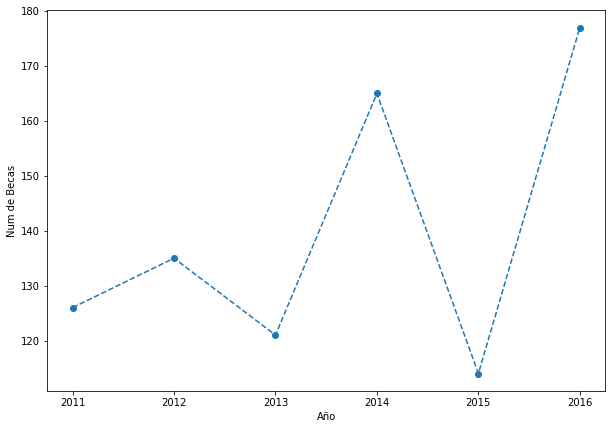

In [14]:
pd.Series(dict(ofertas_año)).plot(ls = '--', 
                                  marker = 'o', 
                                  xlabel = 'Año', 
                                  ylabel = 'Num de Becas', figsize = (10,7))

##**C) Paises que han ofrecido becas**

Presente un listado con todos los países (diferentes de Colombia) de los que se tiene reporte que han ofrecido becas para estudiantes colombianos (*solamente presentar nombres de países, y estos solo deben aparecer una única vez en la lista*)

Presente aquí el código desarrollado y el resultado obtenido

In [15]:
reemplazo_dict = {'BARBADOS JAMAICA & TRINIDAD Y TOBAGO':'BARBADOS,JAMAICA,TRINIDAD Y TOBAGO', 
             'ESTADOS UNIDOS MEXICANOS ESPAÑA Y ALEMANIA':'ESTADOS UNIDOS MEXICANOS,ESPAÑA,ALEMANIA',
             'ESTADOS UNIDOS REINO UNIDO EMIRATOS ÁRABES CHINA.':'ESTADOS UNIDOS,REINO UNIDO,EMIRATOS ÁRABES,CHINA'}

broadcastReemplazo = sc.broadcast(reemplazo_dict)

def reemplazo(code):
    return broadcastReemplazo.value.get(code,code)

In [16]:
paises = becas_clean \
          .filter(lambda x: all(i not in ' '.join(x[4]) for i in ['PLATAFORMA','COLOMBIA'])) \
          .map(lambda x: x[4][0]) \
          .map(lambda x: reemplazo(x)) \
          .flatMap(lambda x:x.split(",")) \
          .map(lambda x: (x,1)) \
          .reduceByKey(lambda a,b: a+b) 
             
paises = paises.sortBy(lambda x:-x[1]).collect()

_ = [print(i+1,pais) for i,pais in enumerate(paises)]

# paises.take(5)

1 ('INDIA', 223)
2 ('ISRAEL', 184)
3 ('ESPAÑA', 168)
4 ('PERÚ', 91)
5 ('COREA DEL SUR', 86)
6 ('REINO UNIDO', 53)
7 ('EGIPTO', 48)
8 ('JAPÓN', 46)
9 ('ARGENTINA', 42)
10 ('ESTADOS UNIDOS', 40)
11 ('MÉXICO', 35)
12 ('DIFERENTES PAÍSES', 33)
13 ('CHILE', 24)
14 ('RUSIA', 22)
15 ('BRASIL', 20)
16 ('TAILANDIA', 20)
17 ('CHINA', 18)
18 ('CANADÁ', 16)
19 ('SINGAPUR', 16)
20 ('ITALIA', 16)
21 ('PANAMÁ', 13)
22 ('SUECIA', 13)
23 ('AUSTRALIA', 9)
24 ('MALASIA', 9)
25 ('URUGUAY', 7)
26 ('INDONESIA', 7)
27 ('ECUADOR', 6)
28 ('CHECA REP.', 6)
29 ('HUNGRÍA', 6)
30 ('TAIWÁN', 6)
31 ('FRANCIA', 6)
32 ('TURQUÍA', 6)
33 ('POLONIA', 5)
34 ('COSTA RICA', 5)
35 ('SUIZA', 5)
36 ('PARAGUAY', 5)
37 ('BÉLGICA', 5)
38 ('TRINIDAD Y TOBAGO', 4)
39 ('BARBADOS', 3)
40 ('JAMAICA', 3)
41 ('NUEVA ZELANDA', 2)
42 ('BELICE', 2)
43 ('BRUNÉI', 2)
44 ('ESTADOS UNIDOS MEXICANOS', 2)
45 ('ALEMANIA', 2)
46 ('EMIRATOS ÁRABES', 2)
47 ('HONDURAS', 1)
48 ('PUERTO RICO', 1)
49 ('NICARAGUA', 1)


##**D) Áreas del conocimiento y Posgrados**

Se desea averiguar cúal es el área de conocimiento predominante por país. Además, queremos conocer qué porcentaje de los programas ofrecidos (**de acuerdo al nombre del programa**) corresponden a estudios de posgrado.

Presente aquí el código desarrollado y el resultado obtenido

In [17]:
import re
from operator import add
def normalize_area(x):
  if re.match(".*(ADMIN|ECONOM).*", x):
    return "ADMINISTRACIÓN, ECONOMÍA Y AFINES"
  elif re.match(".*(DOCTORADO|MAESTR|POSGRADO).*", x):
    return "POSGRADO DIFERENTES AREAS"
  elif re.match(".*(CIENCIAS NATURALES).*", x):
    return "CIENCIAS NATURALES"
  elif re.match(".*(SOCIALES|HUMAN|IDIOM|DERECH).*", x):
    return "CIENCIAS SOCIALES Y HUMANAS"
  elif re.match(".*(ARTE).*", x):
    return "BELLAS ARTES"
  elif re.match(".*(INGENIE|URBANIS).*", x,re.I):
    return "INGENIERÍA, ARQUITECTURA Y URBANISMO"
  else:
    return x

In [18]:
areasXPais = becas_clean.filter(lambda x: all(i not in ' '.join(x[4]) for i in ['PLATAFORMA'])) \
                        .map(lambda x: (x[4][0] + '|' + normalize_area(x[2]),1)) \
                        .reduceByKey(lambda a,b: a+b) \
                        .map(lambda x: (x[0].split('|')[0],(x[0].split('|')[1], x[1])))
areasXPais.take(5)

[('CHINA', ('DIFERENTES AREAS', 2)),
 ('ESPAÑA', ('POSGRADO DIFERENTES AREAS', 33)),
 ('BRASIL', ('CIENCIAS SOCIALES Y HUMANAS', 7)),
 ('INDIA', ('CIENCIAS NATURALES', 4)),
 ('SUIZA', ('POSGRADO DIFERENTES AREAS', 5))]

In [19]:
areasXPais \
  .reduceByKey(lambda a,b: max((a,b), key=lambda x: x[1])) \
  .sortBy(lambda x: x[1][1], ascending=False) \
  .collect()

[('INDIA', ('INGENIERÍA, ARQUITECTURA Y URBANISMO', 94)),
 ('ESPAÑA', ('ADMINISTRACIÓN, ECONOMÍA Y AFINES', 77)),
 ('EGIPTO', ('CIENCIAS AGROPECUARIAS', 48)),
 ('COREA DEL SUR', ('ADMINISTRACIÓN, ECONOMÍA Y AFINES', 40)),
 ('ISRAEL', ('CIENCIAS DE LA EDUCACION', 39)),
 ('PERÚ', ('INGENIERÍA, ARQUITECTURA Y URBANISMO', 31)),
 ('ARGENTINA', ('ADMINISTRACIÓN, ECONOMÍA Y AFINES', 23)),
 ('MÉXICO', ('DIFERENTES AREAS', 18)),
 ('REINO UNIDO', ('DIFERENTES AREAS', 18)),
 ('JAPÓN', ('DIFERENTES AREAS', 18)),
 ('CHILE', ('DIFERENTES AREAS', 15)),
 ('RUSIA', ('POSGRADO DIFERENTES AREAS', 11)),
 ('ESTADOS UNIDOS', ('INGENIERÍA, ARQUITECTURA Y URBANISMO', 10)),
 ('TAILANDIA', ('CIENCIAS AGROPECUARIAS', 10)),
 ('ITALIA', ('POSGRADO DIFERENTES AREAS', 9)),
 ('CANADÁ', ('POSGRADO DIFERENTES AREAS', 8)),
 ('CHINA', ('POSGRADO DIFERENTES AREAS', 8)),
 ('SINGAPUR', ('ADMINISTRACIÓN, ECONOMÍA Y AFINES', 8)),
 ('BRASIL', ('CIENCIAS SOCIALES Y HUMANAS', 7)),
 ('DIFERENTES PAÍSES', ('POSGRADO DIFERENTES ARE

In [20]:
nombresXPais = becas_clean.filter(lambda x: all(i not in ' '.join(x[4]) for i in ['PLATAFORMA'])) \
                        .map(lambda x: (x[4][0] + '|' + normalize_area(x[3]),1)) \
                        .reduceByKey(lambda a,b: a+b) \
                        .map(lambda x: (x[0].split('|')[0],(x[0].split('|')[1], x[1])))
nombresXPais.take(5)
totalXPais = nombresXPais.map(lambda x: (x[0], x[1][1])).reduceByKey(add)
totalXPais = dict(totalXPais.collect())

In [21]:
program_name = becas_clean.filter(lambda x: all(i not in ' '.join(x[4]) for i in ['PLATAFORMA','DIFERENT'])) \
                   .map(lambda x: (x[4][0], 1 if re.match(".*(POSGRADO|POSTGRADO|DOCTORA|MASTER|MAESTR|SPECIALI).*", x[3], re.I) else 0))\
                   .reduceByKey(lambda a,b: a+b) \
                   .map(lambda x: (x[0], round((x[1]/totalXPais[x[0]])*100,2)))

program_name.sortBy(lambda x: -x[1]).map(lambda x: (x[0], f'{x[1]:.0f} %')).collect()

[('ESTADOS UNIDOS MEXICANOS ESPAÑA Y ALEMANIA', '100 %'),
 ('PUERTO RICO', '100 %'),
 ('SUIZA', '100 %'),
 ('BÉLGICA', '100 %'),
 ('TURQUÍA', '100 %'),
 ('NICARAGUA', '100 %'),
 ('AUSTRALIA', '89 %'),
 ('COREA DEL SUR', '85 %'),
 ('ESPAÑA', '84 %'),
 ('TAIWÁN', '83 %'),
 ('REINO UNIDO', '78 %'),
 ('CHINA', '75 %'),
 ('COSTA RICA', '60 %'),
 ('MÉXICO', '57 %'),
 ('INDONESIA', '57 %'),
 ('CANADÁ', '56 %'),
 ('RUSIA', '50 %'),
 ('ESTADOS UNIDOS REINO UNIDO EMIRATOS ÁRABES CHINA.', '50 %'),
 ('HUNGRÍA', '50 %'),
 ('BRUNÉI', '50 %'),
 ('CHILE', '46 %'),
 ('ITALIA', '38 %'),
 ('ESTADOS UNIDOS', '18 %'),
 ('ECUADOR', '17 %'),
 ('FRANCIA', '17 %'),
 ('URUGUAY', '14 %'),
 ('JAPÓN', '13 %'),
 ('BRASIL', '10 %'),
 ('PERÚ', '8 %'),
 ('ARGENTINA', '7 %'),
 ('INDIA', '4 %'),
 ('ISRAEL', '2 %'),
 ('POLONIA', '0 %'),
 ('EGIPTO', '0 %'),
 ('PANAMÁ', '0 %'),
 ('HONDURAS', '0 %'),
 ('TRINIDAD Y TOBAGO', '0 %'),
 ('CHECA REP.', '0 %'),
 ('NUEVA ZELANDA', '0 %'),
 ('SINGAPUR', '0 %'),
 ('BELICE', '0 %'),
 

##**E) ¿Qué podemos concluir a partir del Perfil del Aspirante y el Objetivo del Programa?**

Se dispone de dos campos de descripción, que no emplean un formato claro que permita analizar los perfiles de los aspirantes con respecto al objetivo del programa.

Plantee una forma de analizar esta información para conocer las relaciones entre los perfiles y lo objetivos.

Presente aquí el código desarrollado y el resultado obtenido

In [22]:
becas_clean.filter(lambda x: all([i not in x[-2].lower() for i  in ['esta dirigido','esta orientado','estan dirigidos', 'esta disenado', 'está dirigido', 'estan dirigidas']])).count()

5

In [23]:
# removeObjetives = 'el,ella,de,es,su,al,y,en,un,una,uno,la,las,a,los,sus,o,se,del,como,\
# que,con,para,mas,esta,este,esto,ya,e,mediante,por,entre,sobre,tal,lo,era,\
# conocimientos,profesionales,habilidades,desarrollo,ofrecer,\
# herramientas,oportunidad'.split(',')

# removePerfil = 'el,ella,de,es,su,al,y,en,un,una,uno,esten,la,las,los,sus,o,se,del\
# ,como,que,con,para,mas,este,esto,ya,e,mediante,por,entre,sobre,tal,lo,era,fue'\
# .split(',')

aux_remove_articles = r'\b{}\b'
aux_split_perfil = '.*({}).*'
keyPhrases = ['esta dirigido','esta orientado','estan dirigidos',
              'esta disenado', 'esta dirigido', 'estan dirigidas']

def split_perfil(x, vslice=slice(2,4,1)):
  x = re.sub('[^A-Za-z\s]+', '', x)
  for i in removePerfil:
    x = re.sub(aux_remove_articles.format(i),'',x)
  x = re.sub(' +', ' ', x)
  if re.match(aux_split_perfil.format(keyPhrases[0]), x):
    return ' '.join(x.split(keyPhrases[0])[1].split(' ')[vslice])
  elif re.match(aux_split_perfil.format(keyPhrases[1]), x):
    return ' '.join(x.split(keyPhrases[1])[1].split(' ')[vslice])
  elif re.match(aux_split_perfil.format(keyPhrases[2]), x):
    return ' '.join(x.split(keyPhrases[2])[1].split(' ')[vslice])
  elif re.match(aux_split_perfil.format(keyPhrases[3]), x):
    return ' '.join(x.split(keyPhrases[3])[1].split(' ')[vslice])
  elif re.match(aux_split_perfil.format(keyPhrases[4]), x):
    return ' '.join(x.split(keyPhrases[4])[1].split(' ')[vslice])
  elif re.match(aux_split_perfil.format(keyPhrases[5]), x):
    return ' '.join(x.split(keyPhrases[5])[1].split(' ')[vslice])
  else:
    return x

def remove_articles(x):
  x = re.sub('[^A-Za-z0-9\s]+', '', x)
  for i in removeObjetives:
    x = re.sub(aux_remove_articles.format(i),'',x)
  x = re.sub(' +', ' ', x)
  return x.strip().split(' ')

In [24]:
from collections import defaultdict

In [25]:
import time

In [26]:
removeObjetives = 'el,ella,de,es,su,al,y,en,un,una,uno,la,las,a,los,sus,o,se,del,como,\
que,con,para,mas,esta,este,esto,ya,e,mediante,por,entre,sobre,tal,lo,era'.split(',')

removePerfil = 'el,ella,de,es,su,al,y,en,un,una,uno,esten,la,las,los,sus,o,se,del\
,como,que,con,para,mas,este,esto,ya,e,mediante,por,entre,sobre,tal,lo,era,fue'\
.split(',')

perfilXObjetivo = becas_clean \
    .filter(lambda x: any([i in x[-2].lower() for i in keyPhrases])) \
    .map(lambda x: (split_perfil(x[-2].lower(),vslice=slice(3)),remove_articles(x[-1]))) \
    .flatMapValues(lambda x: x) \
    .map(lambda x: (x[0]+'|'+x[1], 1)) \
    .reduceByKey(lambda a,b: a+b) \
    .map(lambda x: (x[0].split('|')[0],(x[0].split('|')[1], x[1]))) \
    .reduceByKey(lambda a,b: str(a)+'|'+str(b)) \

In [27]:

def get_top_objetive_words(n):  
  dicc = defaultdict(dict)

  for a in perfilXObjetivo.collect():
    for b in a[1].split('|'):
      dicc[a[0]][b.split(',')[0].strip('(').strip('\'')] = float(b.split(',')[1].strip(')'))
  final_list = []
  for d in dicc.items():
    final_list.append([d[0],sorted(d[1], key=d[1].get, reverse=True)[:n]])
  return final_list


In [28]:
perfilXObjetivo.cache()

start_time = time.time()
get_top_objetive_words(6)
print('first evaluation   >>>>>>>>', time.time()-start_time)

perfilXObjetivo.unpersist();

start_time = time.time()
top5words = get_top_objetive_words(6)
print('second evaluation  >>>>>>>>', time.time()-start_time)



first evaluation   >>>>>>>> 3.3224682807922363
second evaluation  >>>>>>>> 0.09209966659545898


In [29]:
totalProfiles = becas_clean \
    .filter(lambda x: any([i in x[-2].lower() for i in keyPhrases])) \
    .map(lambda x: (split_perfil(x[-2].lower(),vslice=slice(1,3)),1)) \
    .reduceByKey(lambda a,b: a+b) \
    .sortBy(lambda x: x[1], ascending=False)

totalProfiles.collect()

[('a profesionales', 1274),
 ('a bachilleres', 50),
 ('a estudiantes', 45),
 ('a licenciados', 19),
 ('a tecnicos', 12),
 ('a profesores', 9),
 ('a funcionarios', 8),
 ('a ingenieros', 8),
 ('unicamente a', 6),
 ('a jovenes', 6),
 ('a mujeres', 6),
 ('a ciudadanas', 4),
 ('a integrantes', 4),
 ('a medicos', 3),
 ('a investigadores', 3),
 ('profesionales colombianos', 2),
 ('tecnicos profesionales', 2),
 ('profesionales universitarios', 2),
 ('a a', 2),
 ('a personas', 2),
 ('principalmente a', 2),
 ('a oficiales', 2),
 ('a agentes', 1),
 ('a lideres', 1),
 ('a ciudadanos', 1),
 ('a artistas', 1),
 ('a abogados', 1),
 ('a planificadores', 1),
 ('profesionales consultores', 1),
 ('a formuladores', 1),
 ('a jefes', 1)]

##**Análisis de los resultados**

Teniendo en cuenta los resultados obtenidos en los puntos anteriores, presente sus impresiones sobre las becas académicas disponibles para los estudiantes colombianos.


**Notas**

1. Utilice el concepto de persistencia al menos una vez, justificando porque considera que aplicarlo donde lo propone, puede aportar en la solución del taller.

2. Identifique si vale la pena aplicar el concepto de variables compartidas en alguno de los puntos a resolver, justifique su respuesta y en caso de aplicarlo, indique porque considera que puede aportar a la solución del taller